In [1]:
# GET PARAMETERS
import os 
import sys
import torch 
import importlib
import itertools 
import copy 
import torch._dynamo as dynamo; dynamo.graph_break()
torch._dynamo.config.verbose=True

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32  = True
# Get Parent folder : 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from pipeline.utils.loger import LOG
from experiences.common_parameter import possible_target_kwargs, weather_possible_contextual_kwargs, model_configurations,feature_extractor_model_configurations
from experiences.common_parameter import REPEAT_TRIAL,netmob_preprocessing_kwargs


from experiences.compilation_parameter import compilation_modification
from experiences.loop_train_save_log import loop_train_save_log,train_one_config

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible
Training and Hyper-parameter tuning with Ray is not possible



In [2]:
loger = LOG()
SANITY_CHECKER = False # True
device = torch.device('cuda:1')
init_save_folder = 'K_fold_validation/training_wo_HP_tuning/Exp8_clipping'
# --- Init ---  (set horizon, freq, ...)
# Set seed : NO 


freq = '15min' #'15min'  
horizons = [1] # [4]  #[1,4]
target_data = 'subway_in' 
contextual_dataset_names = ['netmob_POIs']
add_name_save = 'no_clipping'  # ''  # '_trial2'

model_name = 'STAEformer'
config_backbone_model = model_configurations[model_name]
config_backbone_model['epochs'] = 10 # 150 # 150 #80
# config_backbone_model['batch_size'] = 128 # 150 #80
compilation_modification['torch_compile'] = False #'compile' # 'compile' # 'compile'  # False 
compilation_modification['device'] = device
compilation_modification['grad_clipping_norm'] = 1.0  # 1.0 # None
REPEAT_TRIAL  = 1 

# --- Contextual Data & Hyperparameters : ---
adp_emb, init_adp_q, context_input_emb,input_emb,agg_iris_target_n = 16,24,24,24,100
apps =['Google_Maps', 'Web_Weather']
dic_configs = {}

weather_contextual_kwargs = weather_possible_contextual_kwargs['early_fusion']['repeat_t_proj']
subway_possible_contextual_kwargs = {'late_fusion':{}}
contextual_kwargs_i = copy.deepcopy(feature_extractor_model_configurations)
contextual_kwargs_i.update(netmob_preprocessing_kwargs['contextual_kwargs']['netmob_POIs'])
contextual_kwargs_i['attn_kwargs']['adaptive_embedding_dim'] = adp_emb
contextual_kwargs_i['attn_kwargs']['init_adaptive_query_dim'] = init_adp_q
contextual_kwargs_i['attn_kwargs']['contextual_input_embedding_dim'] = context_input_emb
contextual_kwargs_i['attn_kwargs']['input_embedding_dim'] = input_emb
contextual_kwargs_i['attn_kwargs']['concatenation_late'] = True
contextual_kwargs_i['attn_kwargs']['cross_attention'] = True
contextual_kwargs_i['backbone_model'] = True
contextual_kwargs_i['agg_iris_target_n'] = agg_iris_target_n
contextual_kwargs_i['NetMob_selected_apps'] = apps
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---


# --- --- --- Name --- --- --- 
if agg_iris_target_n is not None:
    name_i = f"CrossAttnBackBone_InEmb{input_emb}_ctxInEmb{context_input_emb}_adp{adp_emb}_adpQ{init_adp_q}_aggIris{agg_iris_target_n}"
else:
    name_i = f"CrossAttnBackBone_InEmb{input_emb}_ctxInEmb{context_input_emb}_adp{adp_emb}_adpQ{init_adp_q}"

name_begin = '_'.join(apps)
    
name_save = f"{name_begin}_{name_i}{add_name_save}"

subway_possible_contextual_kwargs['late_fusion'][name_save] =  contextual_kwargs_i
# --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---



for fusion_type, config_contextual_kwargs in subway_possible_contextual_kwargs.items():
    for feature_extractor_type, contextual_kwargs_i in config_contextual_kwargs.items():
    
        contextual_kwargs ={'subway_out':contextual_kwargs_i,
                            'subway_in':contextual_kwargs_i,
                            'subway_in_subway_out':contextual_kwargs_i,
                            'weather':weather_contextual_kwargs,
                            'netmob_POIs':contextual_kwargs_i
                            }
        
        if 'weather' not in contextual_dataset_names:
            contextual_kwargs.pop('weather',None)  
        if 'subway_in' not in contextual_dataset_names:
            contextual_kwargs.pop('subway_in',None)  
        if 'subway_out' not in contextual_dataset_names:
            contextual_kwargs.pop('subway_out',None)
        if 'subway_in_subway_out' not in contextual_dataset_names:
            contextual_kwargs.pop('subway_in_subway_out',None) 
        if 'netmob_POIs' not in contextual_dataset_names:
            contextual_kwargs.pop('netmob_POIs',None)


        for horizon in horizons:
            for n_bis in range(1,REPEAT_TRIAL+1): # range(1,6):
                dataset_names =  [target_data] +contextual_dataset_names+ ['calendar']
                name_i = f"{model_name}_{'_'.join(dataset_names)}_{fusion_type}_{feature_extractor_type}"
                name_i_end = f"_e{config_backbone_model['epochs']}_h{horizon}_bis{n_bis}"
                name_i = f"{name_i}_{name_i_end}"

                config_i =  {'target_data': target_data,
                            'dataset_names': dataset_names,
                            'model_name': model_name,
                            'dataset_for_coverage': [target_data],
                            'freq': freq,
                            'horizon_step': horizon,
                            'step_ahead': horizon,
                            'target_kwargs' : {target_data: possible_target_kwargs[target_data]},
                            'contextual_kwargs' : contextual_kwargs,
                            'denoising_names':[],
                            'bool_sanity_checker' : SANITY_CHECKER 
                            } 
                
                if 'denoiser_kwargs' in netmob_preprocessing_kwargs.keys():
                    config_i.update({'denoising_names':['netmob_POIs'],
                                    'denoiser_names':["exponential"],   # ['median'], ['exponential'], ['savitzky_golay']         # un seul filtre
                                    'denoiser_kwargs': netmob_preprocessing_kwargs['denoiser_kwargs']}
                                    )
                    
                config_i.update(config_backbone_model)
                config_i.update(compilation_modification)

                dic_configs[name_i] = config_i

In [3]:
for trial_id,config_i in dic_configs.items():
    print(f"Training for configuration : {trial_id} ...")
    trainer,ds,model,args = train_one_config(loger,config_i,init_save_folder,trial_id)

Training for configuration : STAEformer_subway_in_netmob_POIs_calendar_late_fusion_Google_Maps_Web_Weather_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100no_clipping__e10_h1_bis1 ...
    Save folder: /home/rrochas/prediction-validation/save/K_fold_validation/training_wo_HP_tuning/Exp8_clipping/subway_in_STAEformer/STAEformer_subway_in_netmob_POIs_calendar_late_fusion_Google_Maps_Web_Weather_CrossAttnBackBone_InEmb24_ctxInEmb24_adp16_adpQ24_aggIris100no_clipping__e10_h1_bis1
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2821, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST cont

In [ ]:
# No clipping: 
# epochs = 20   All Steps RMSE = 41.233, MAE = 25.265, MASE = 0.808, MAPE = 37.533
# epochs = 100  All Steps RMSE = 36.836, MAE = 21.845, MASE = 0.698, MAPE = 27.625

# Clipping : 
# epochs = 10   All Steps RMSE = 51.931, MAE = 32.325, MASE = 1.034, MAPE = 41.382
# epochs = 100  All Steps RMSE = 39.114, MAE = 22.986, MASE = 0.735, MAPE = 32.939
# epochs = 200  All Steps RMSE = 37.821, MAE = 22.355, MASE = 0.715, MAPE = 31.843

# Visalualisation 
- Analyse des attention score au sein du STAEformer et du BackBone model 

torch.Size([3760, 40, 7, 7]) Std on dim 1:  0.004700432065874338 Min/Max:  0.1402016282081604 0.15010909736156464
torch.Size([3760, 40, 7, 7]) Std on dim 1:  0.0076018888503313065 Min/Max:  0.13694638013839722 0.16501355171203613
torch.Size([3760, 40, 7, 7]) Std on dim 1:  0.00863588321954012 Min/Max:  0.13907676935195923 0.15220403671264648
torch.Size([3760, 7, 40, 40]) Std on dim 1:  0.0022040321491658688 Min/Max:  0.019965143874287605 0.031902626156806946
torch.Size([3760, 7, 40, 40]) Std on dim 1:  0.0006189492414705455 Min/Max:  0.023761747404932976 0.02641252428293228
torch.Size([3760, 7, 40, 40]) Std on dim 1:  0.00028164233663119376 Min/Max:  0.024729130789637566 0.025323957204818726


<Figure size 2000x1000 with 0 Axes>

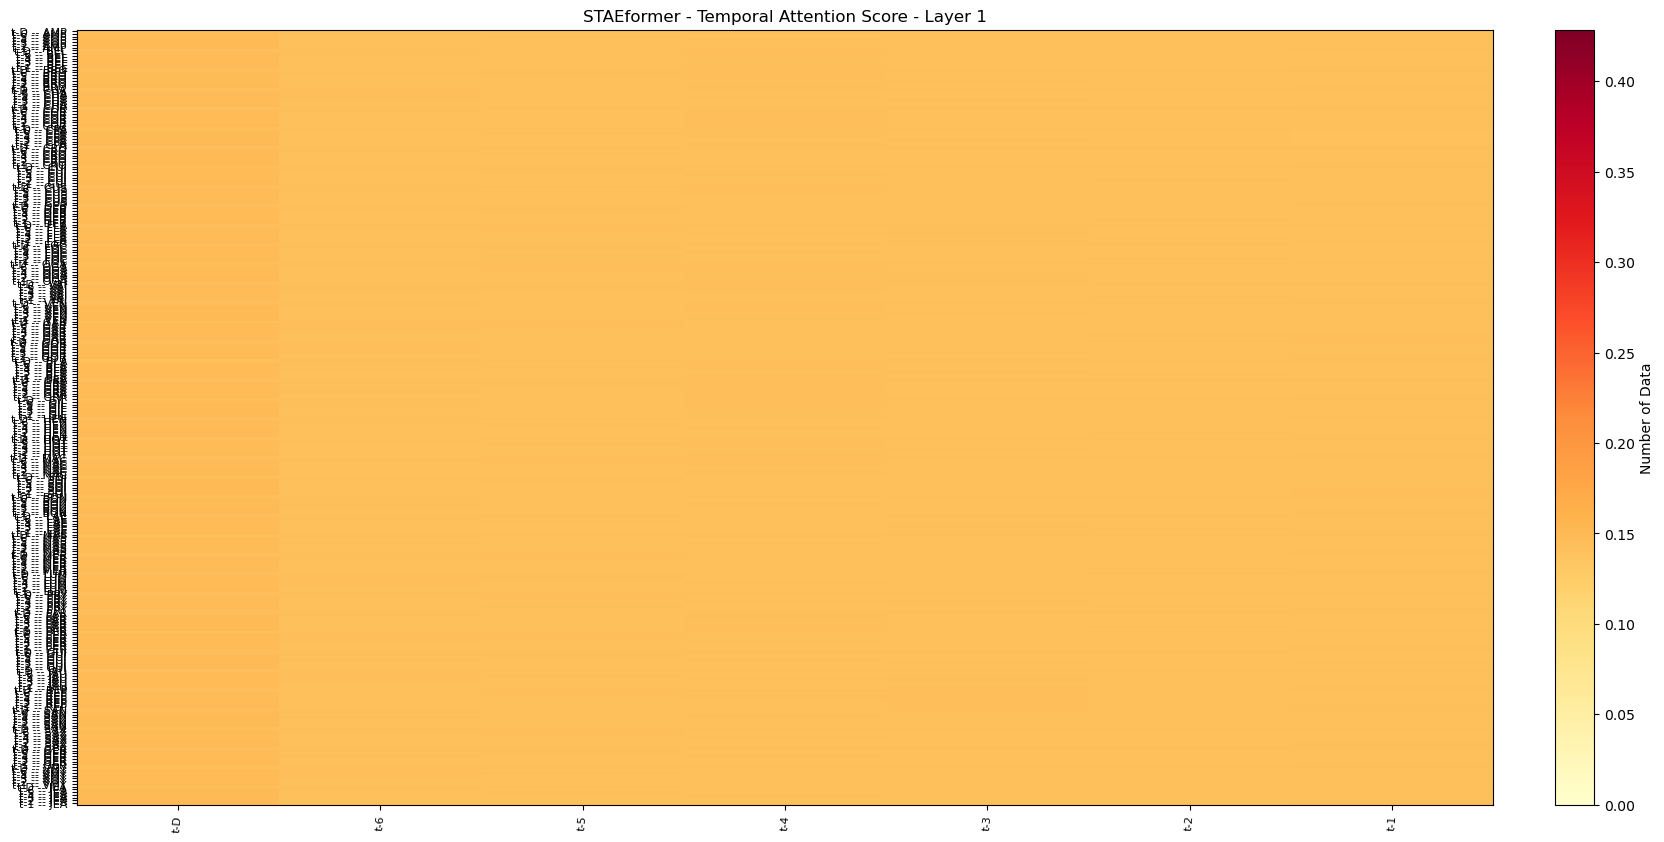

<Figure size 2000x1000 with 0 Axes>

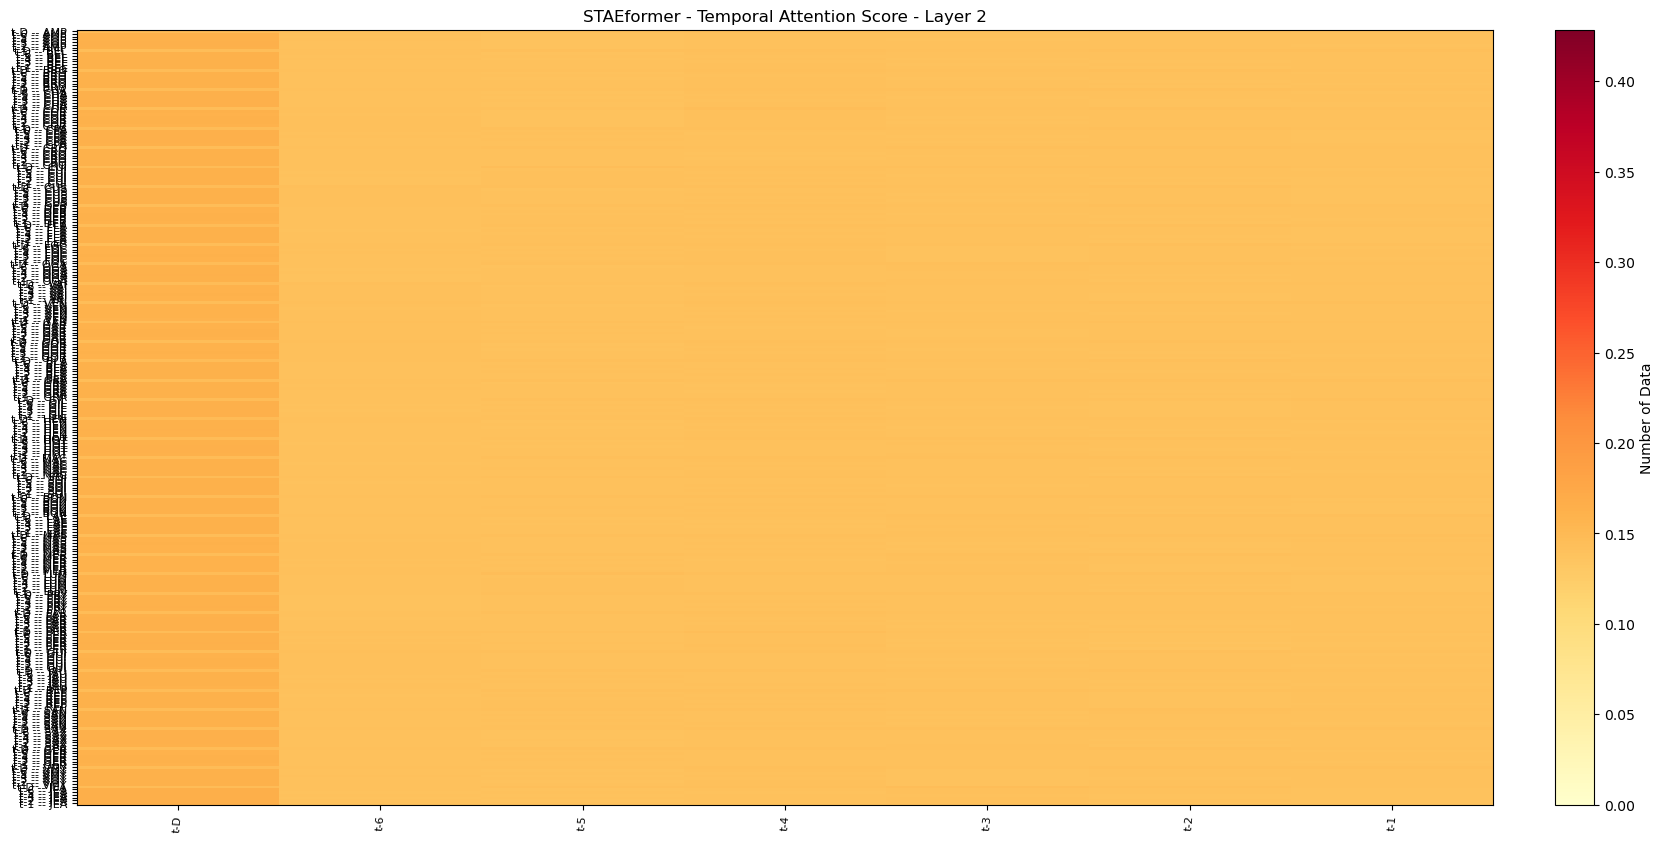

<Figure size 2000x1000 with 0 Axes>

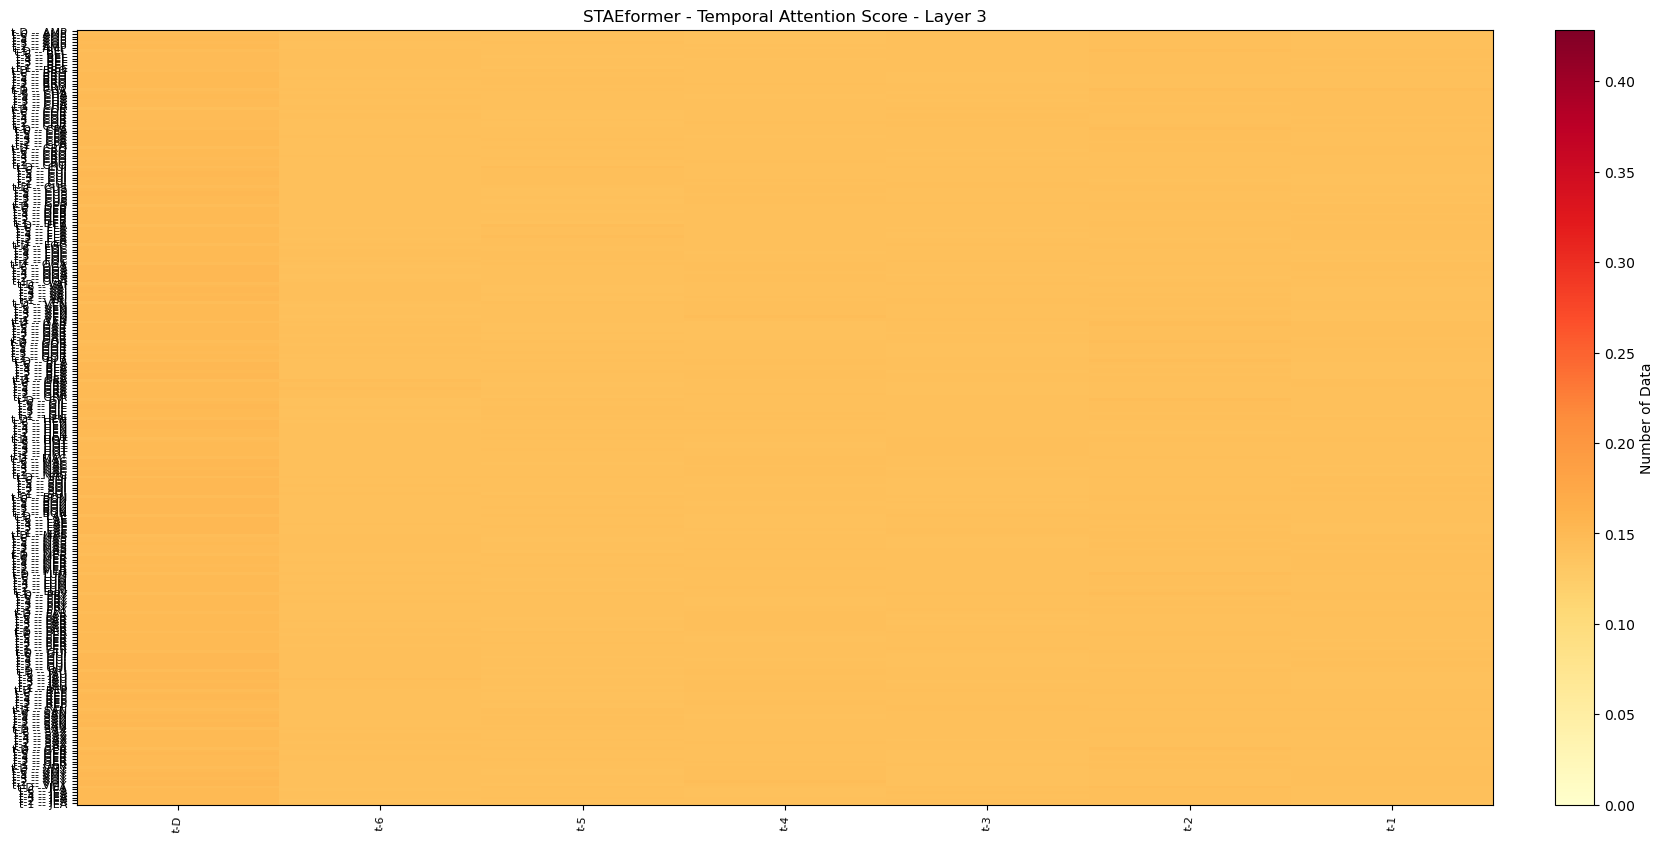

<Figure size 2000x1000 with 0 Axes>

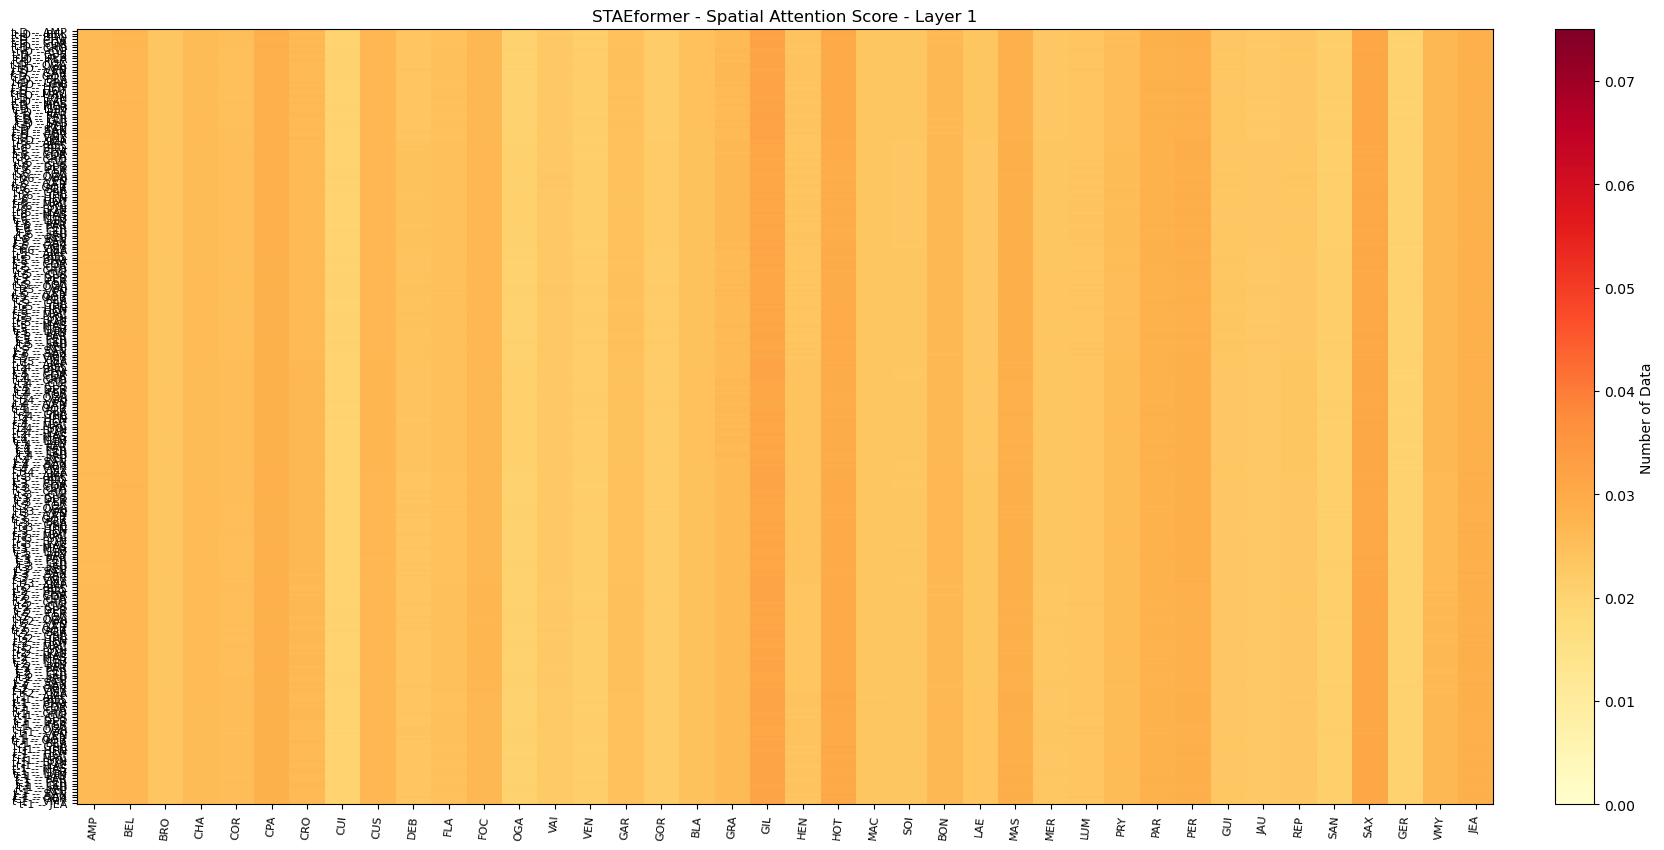

<Figure size 2000x1000 with 0 Axes>

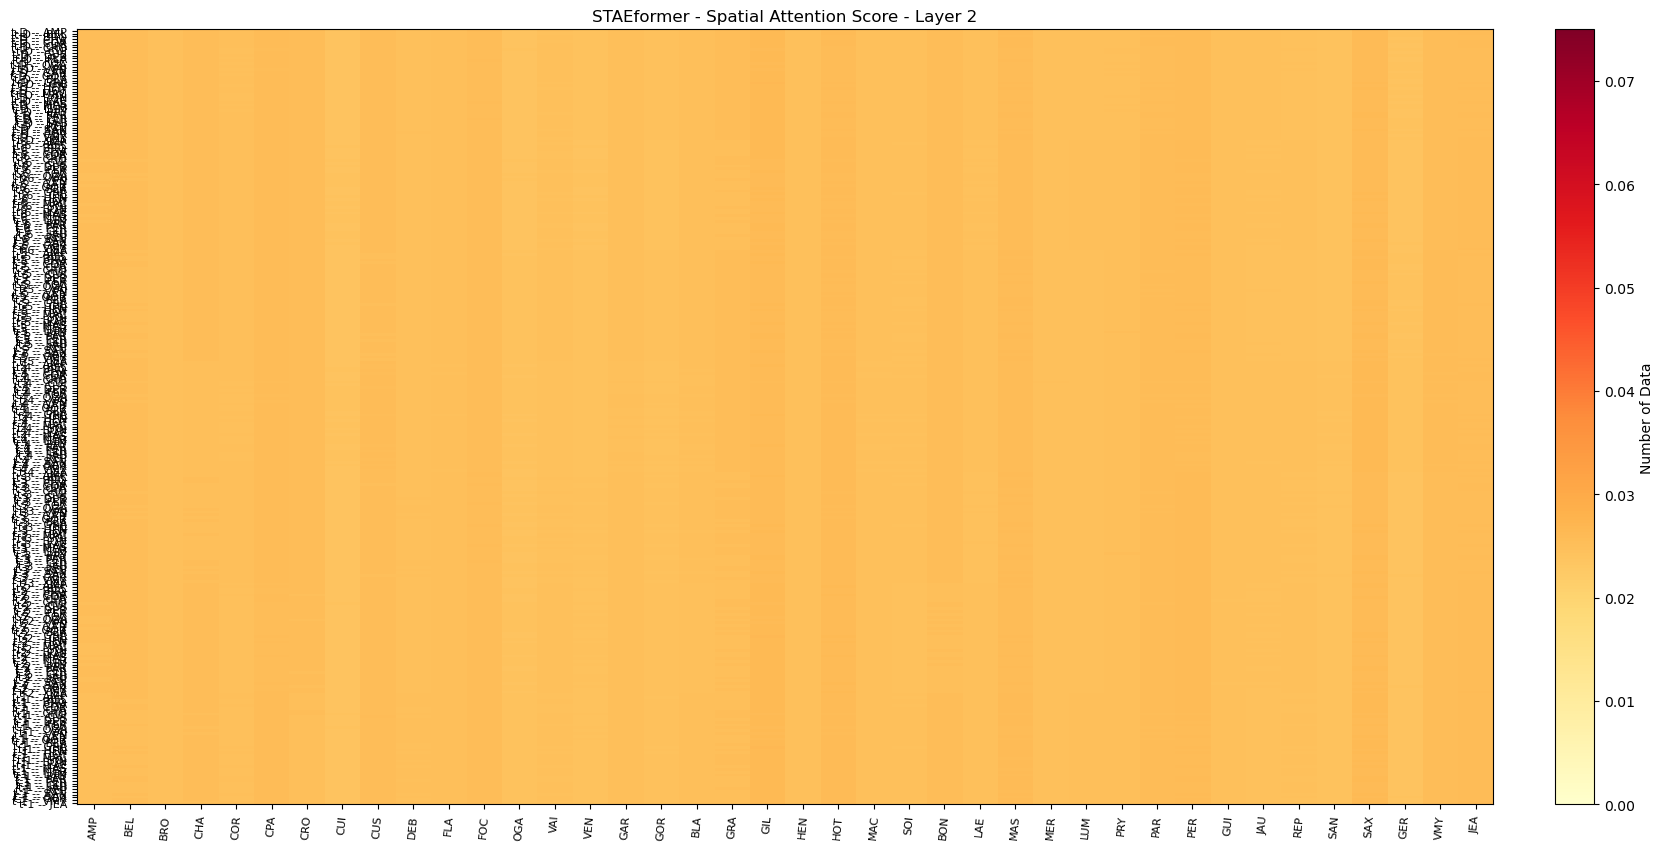

<Figure size 2000x1000 with 0 Axes>

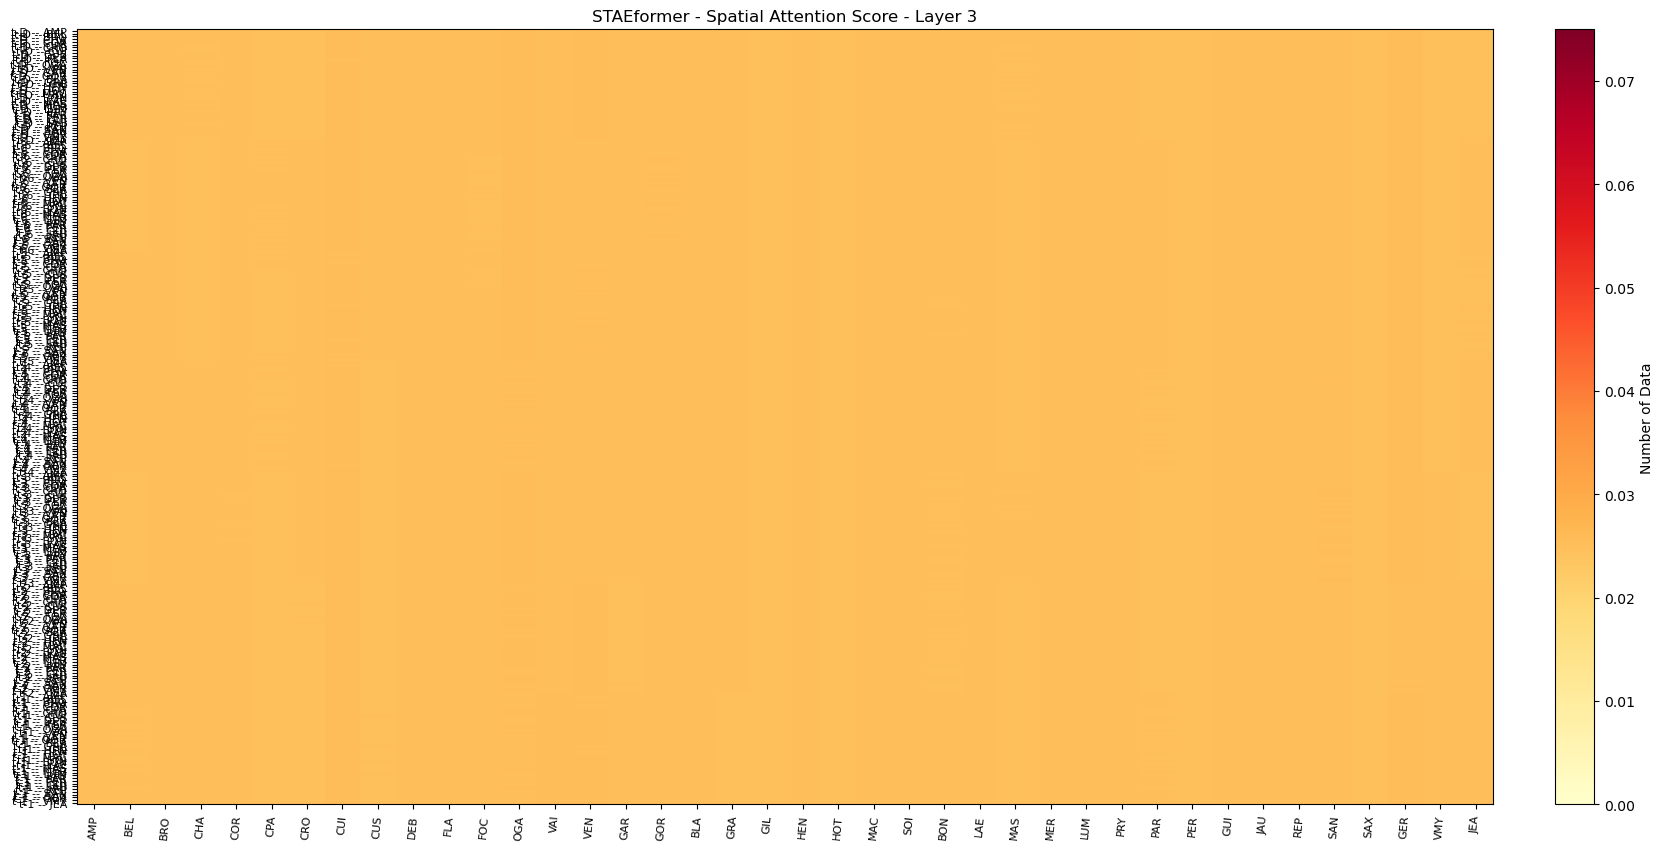

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pipeline.plotting.plotting import plot_coverage_matshow

t_columns = ['t-D','t-6','t-5','t-4','t-3','t-2','t-1']

# Forward on test set to get Attention weights: 
all_data = [tensors for tensors in zip(*trainer.dataloader['test'])]
X = torch.cat(all_data[0]).to(args.device)
Y = torch.cat(all_data[1]).to(args.device)
Xc = [torch.cat(context_tensors).to(args.device) for context_tensors in zip(*all_data[2])]
model = trainer.model
model.eval()
with torch.no_grad():
    pred = model(X, Xc)
# ---

if hasattr(trainer.model,'_orig_mod'):
   t_layers = trainer.model._orig_mod.core_model.attn_layers_t
else:
   t_layers = trainer.model.core_model.attn_layers_t
for temporal_layer in range(len(t_layers)):
  attn_score = t_layers[temporal_layer].attn.attn_score.detach().cpu()     # attn_score.size : torch.Size([19956, 40, 7, 7]) - - [B,N,L,L] 
  print(attn_score.size(),'Std on dim 1: ',attn_score.std(1).mean().item(),'Min/Max: ',attn_score.mean(0).min().item(),attn_score.mean(0).max().item())
  mean_attn_score = attn_score.mean(0)                                                                             #  mean_attn_score.size(): [40, 7, 7]             - -   [N,L,L]
  df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.shape[-1]).numpy(),columns=t_columns,index=[f"{hist} -- {station_name}"   for station_name in ds.spatial_unit for hist in t_columns] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  title = f"STAEformer - Temporal Attention Score - Layer {temporal_layer+1}"
  plot_coverage_matshow(df_attn_weight, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                          v_min=0,v_max=3*(1/df_attn_weight.shape[1]),
                          #   display_values = False,
                           bool_plot = True,
                           cbar_magic_args = True,
                           figsize = figsize,
                           title=title
  )


if hasattr(trainer.model,'_orig_mod'):
   s_layers = trainer.model._orig_mod.core_model.attn_layers_s
else:
   s_layers = trainer.model.core_model.attn_layers_s

for temporal_layer in range(len(s_layers)):
  attn_score = s_layers[temporal_layer].attn.attn_score.detach().cpu()
  print(attn_score.size(),'Std on dim 1: ',attn_score.std(1).mean().item(),'Min/Max: ',attn_score.mean(0).min().item(),attn_score.mean(0).max().item())
  mean_attn_score = attn_score.mean(0)
  df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.shape[-1]).numpy(),columns=ds.spatial_unit,index=[f"{hist} -- {station_name}"   for hist in t_columns  for station_name in ds.spatial_unit] )
  figsize=(20,10)
  matfig = plt.figure(figsize=figsize)
  title = f"STAEformer - Spatial Attention Score - Layer {temporal_layer+1}"
  plot_coverage_matshow(df_attn_weight, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False,
                           v_min=0,v_max=3*(1/df_attn_weight.shape[1]),
                          #   display_values = False,
                            bool_plot = True,
                            cbar_magic_args = True,
                            figsize = figsize,title=title
  )

<Figure size 2000x1000 with 0 Axes>

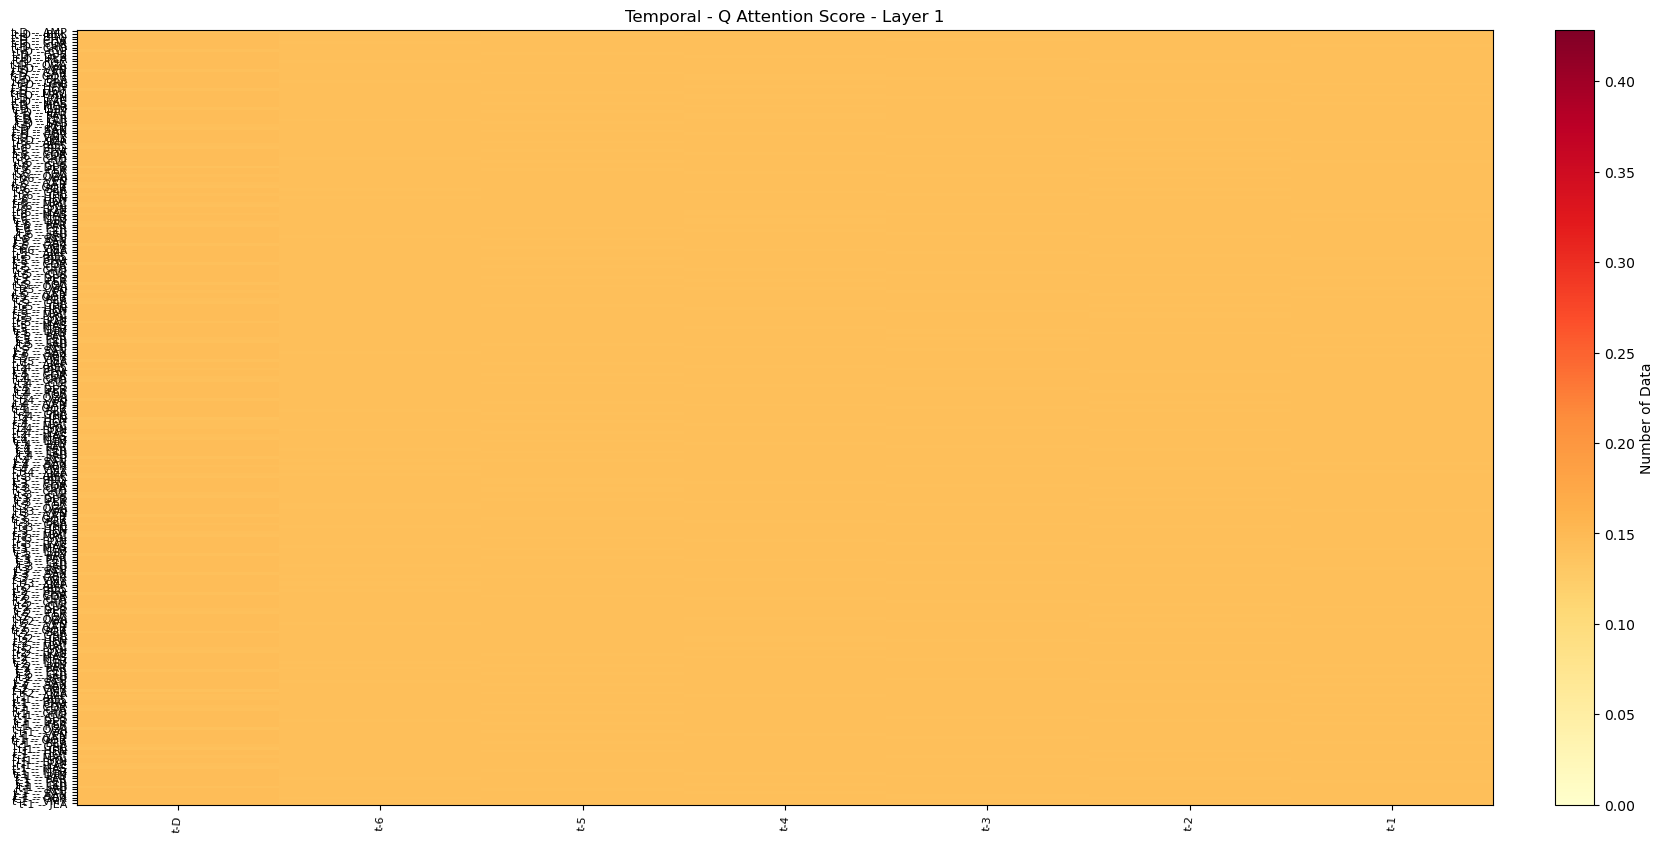

<Figure size 2000x1000 with 0 Axes>

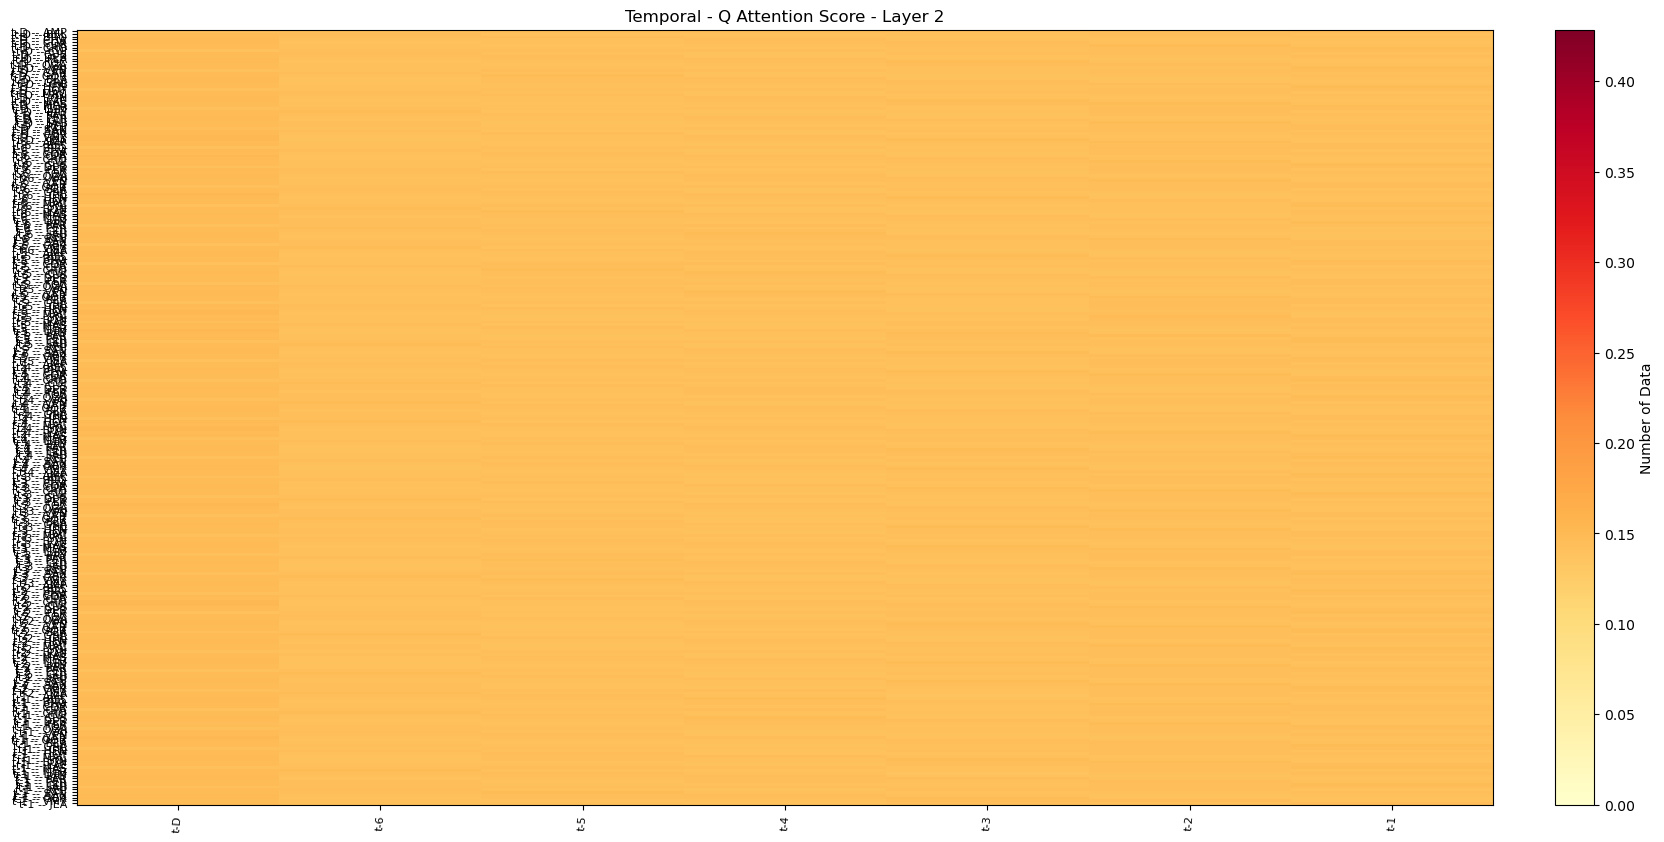

<Figure size 2000x1000 with 0 Axes>

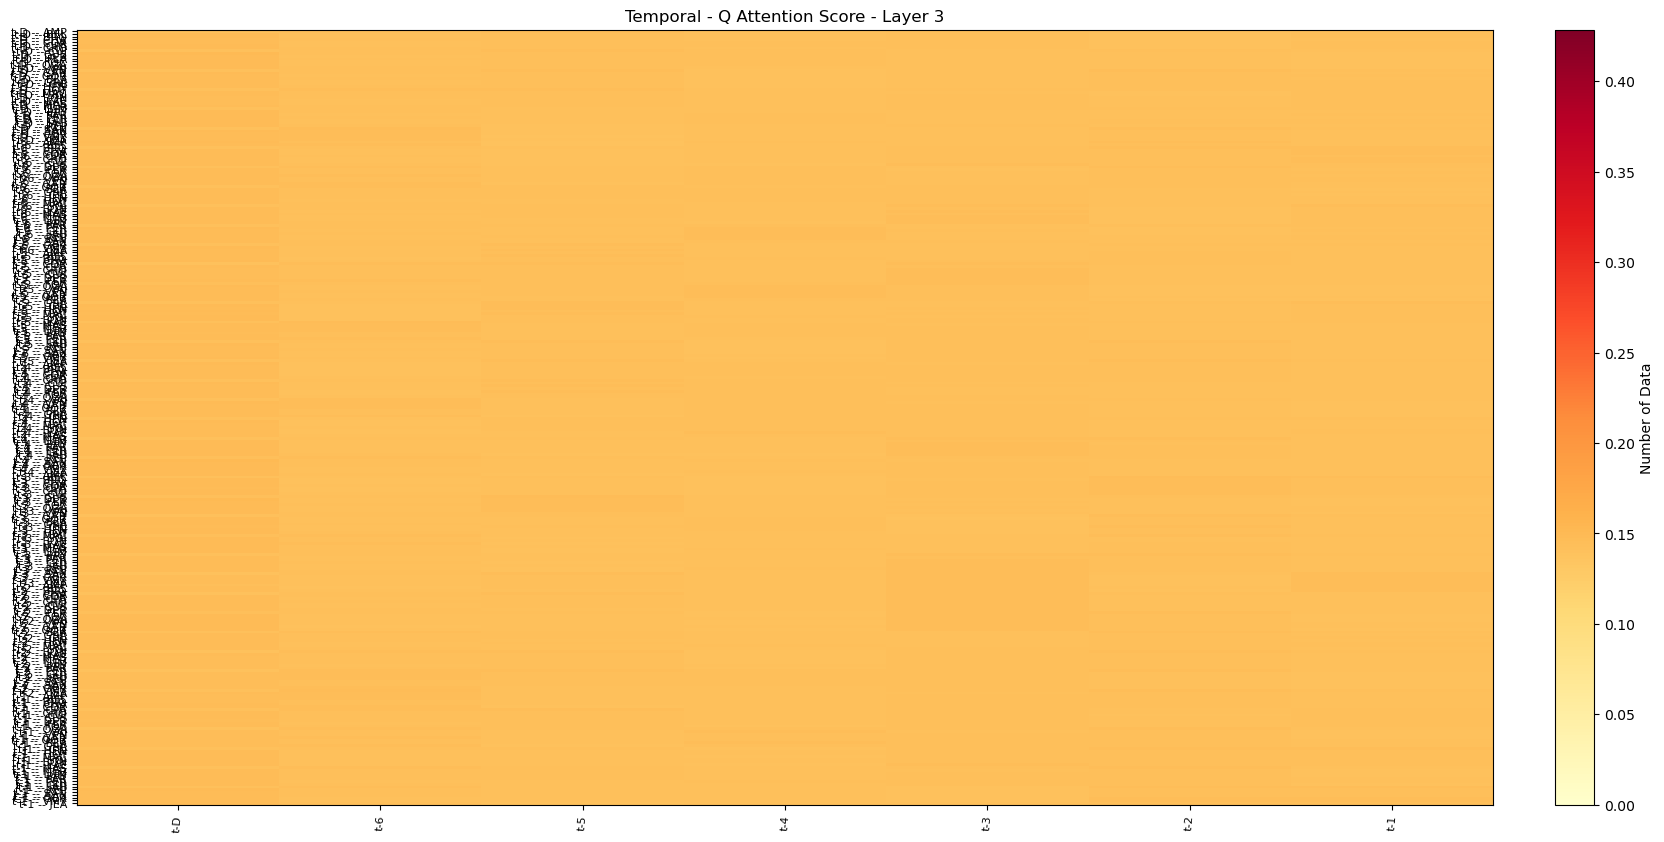

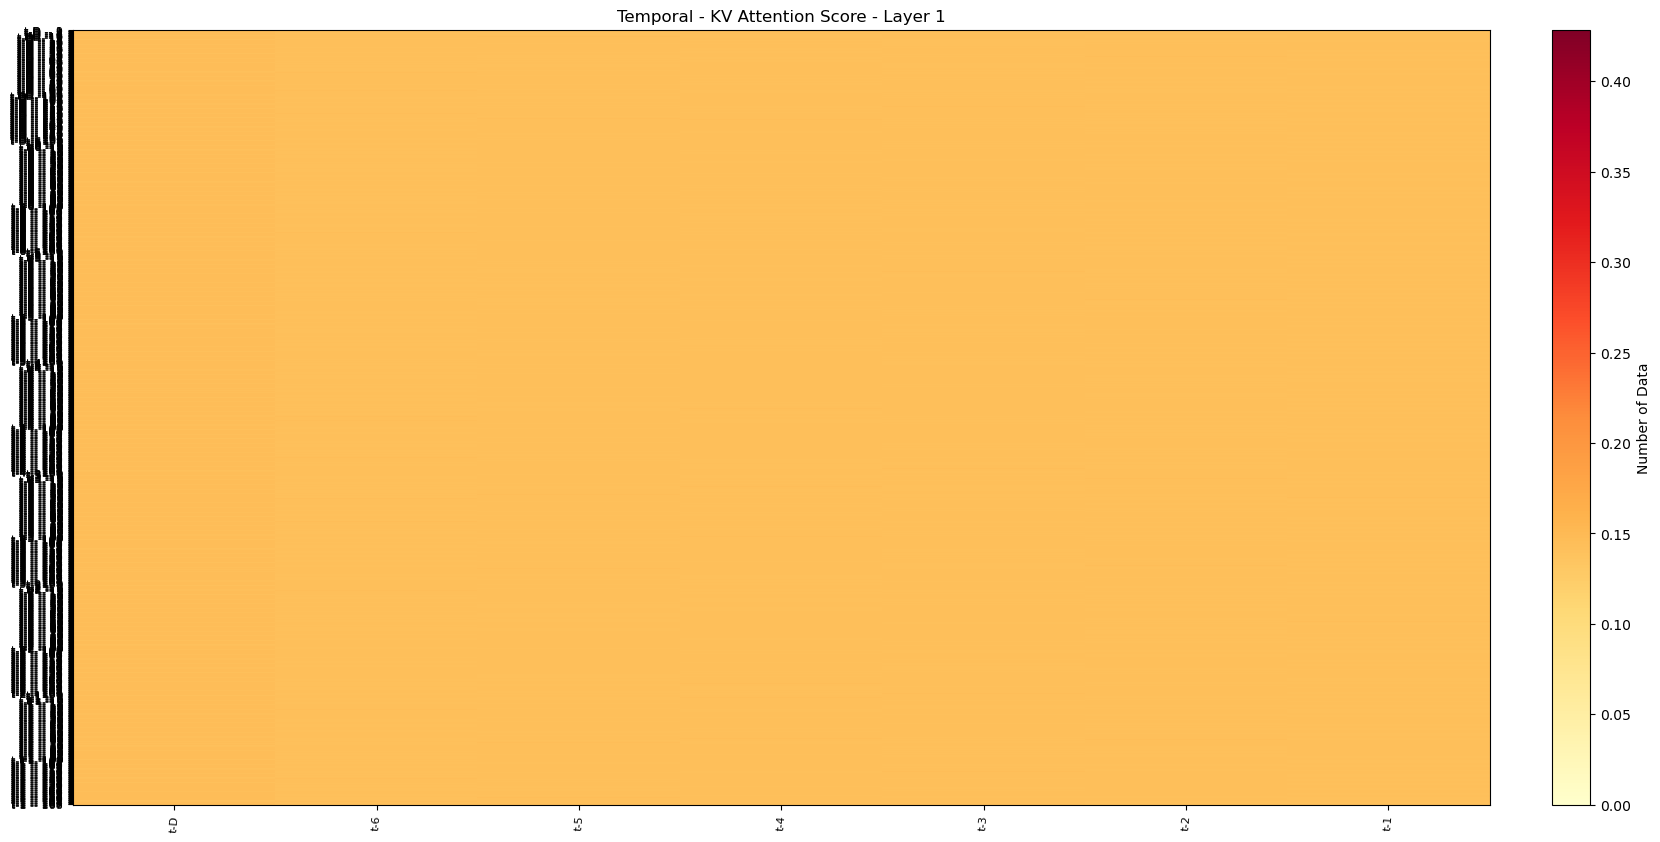

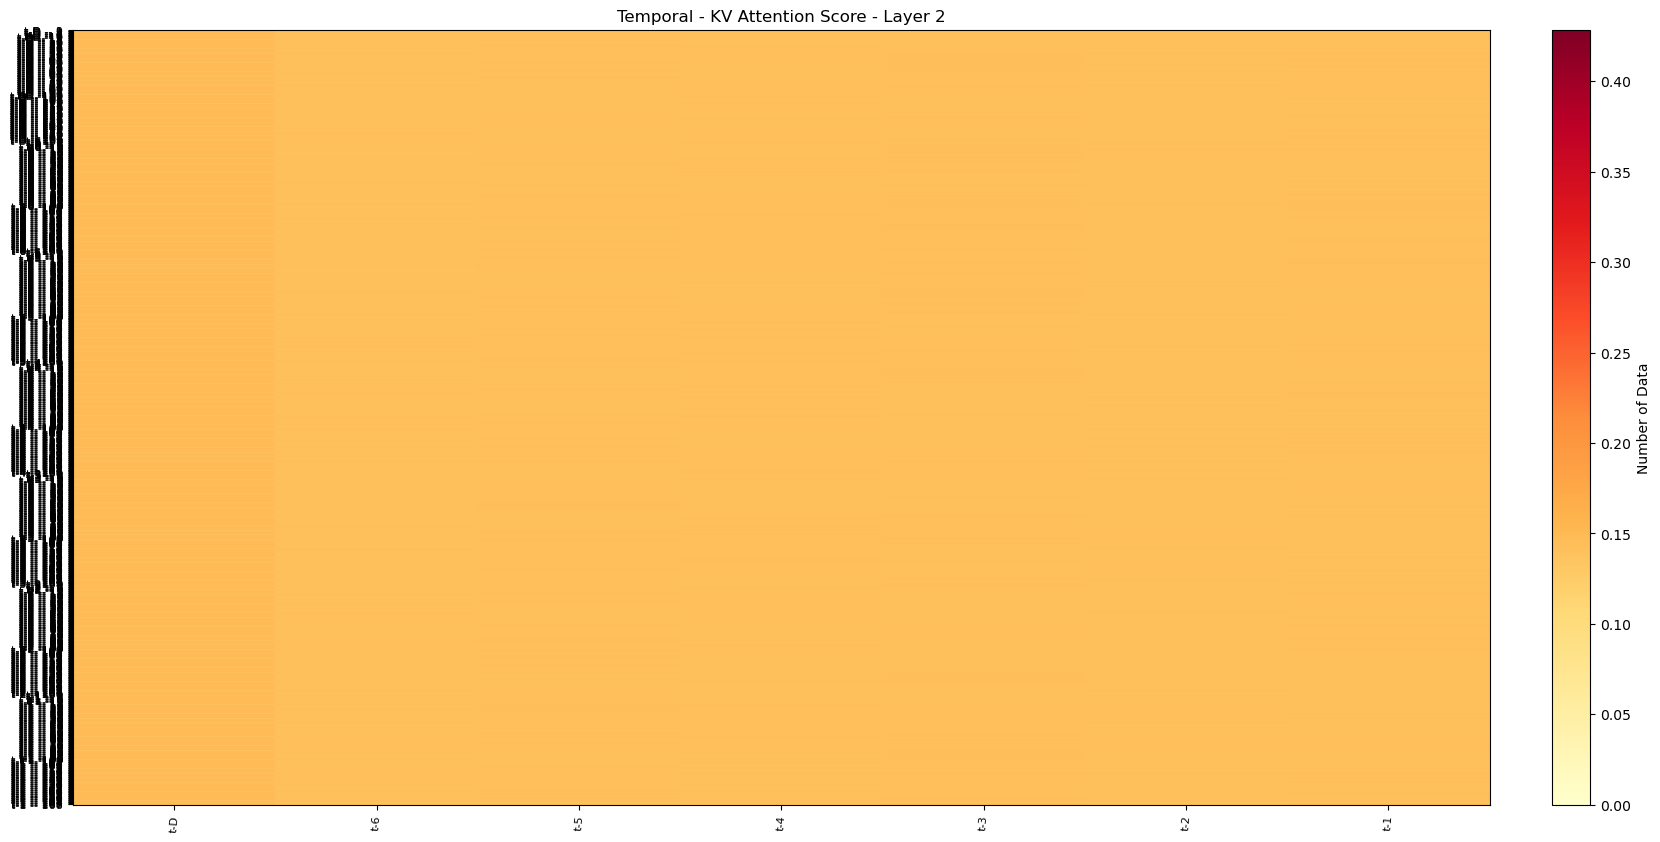

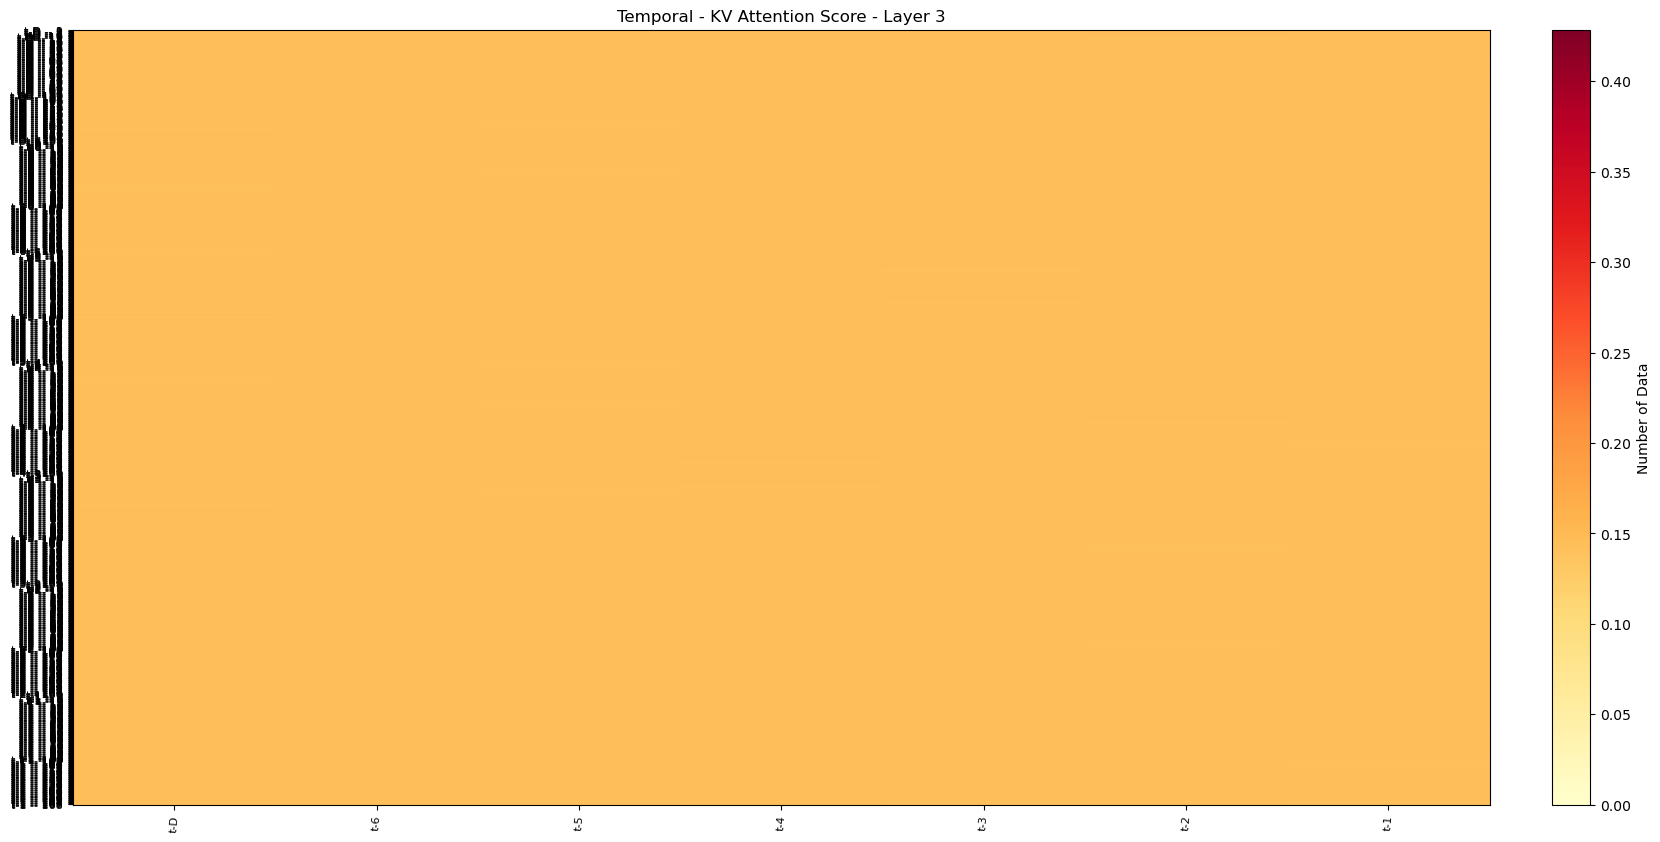

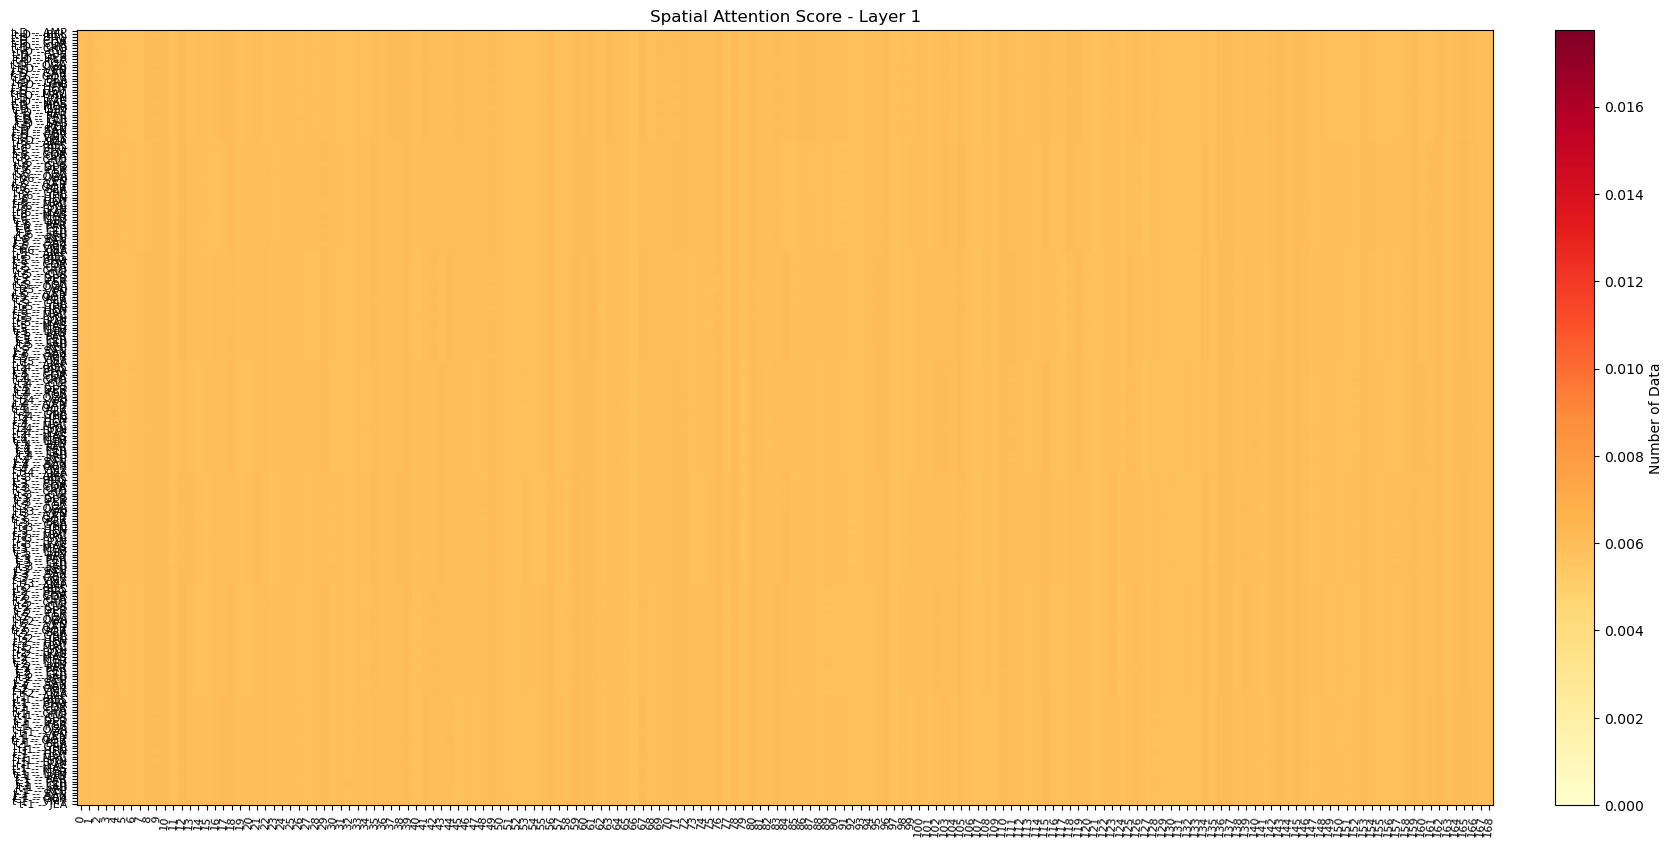

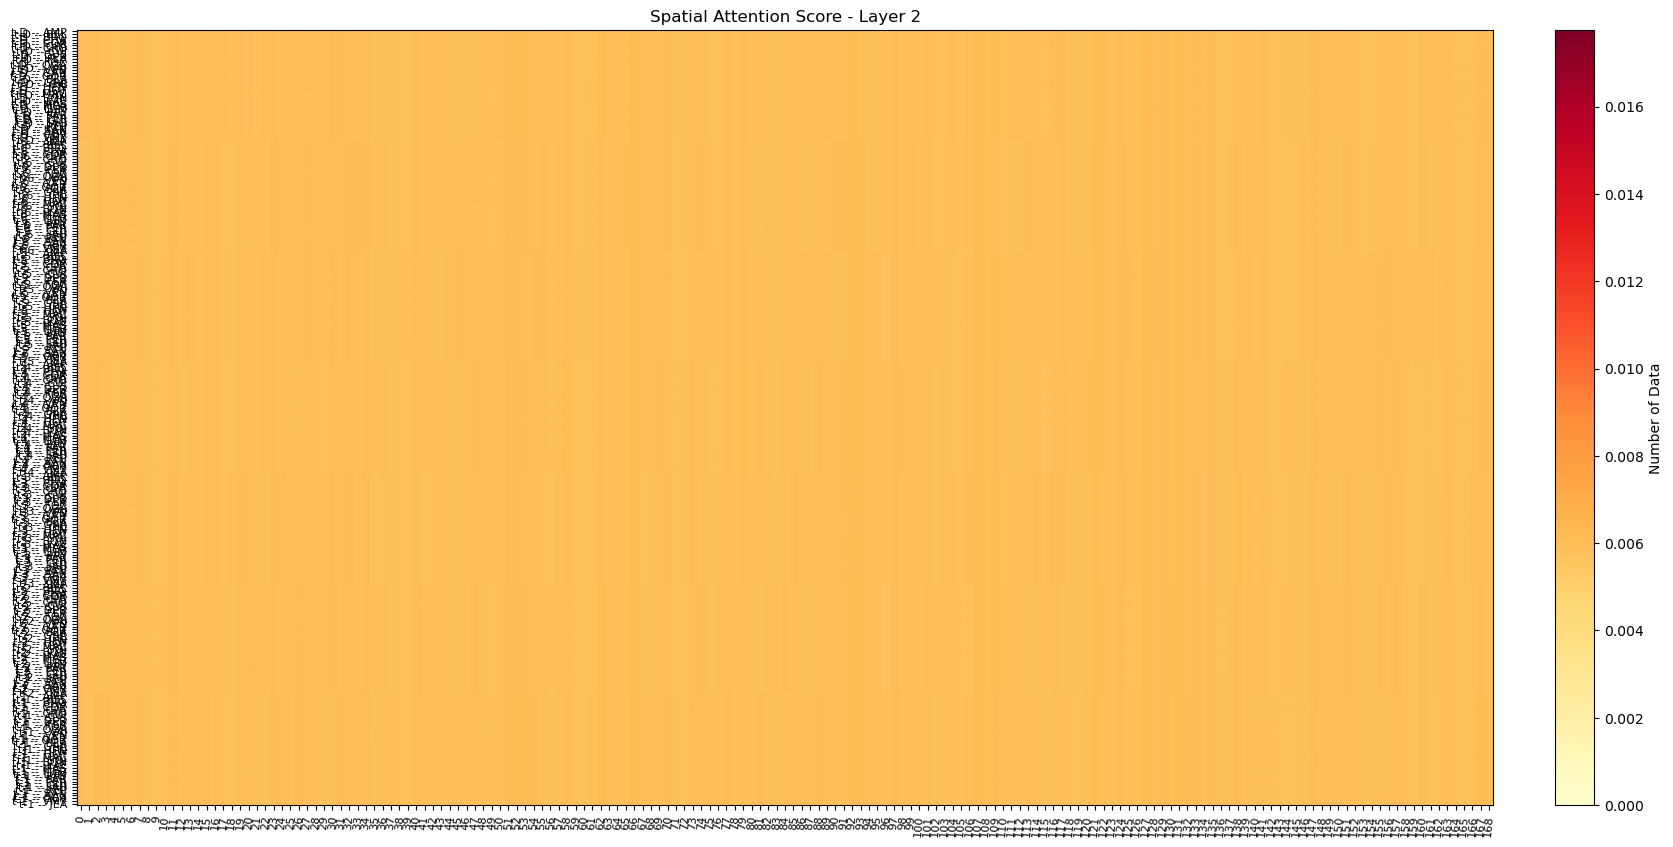

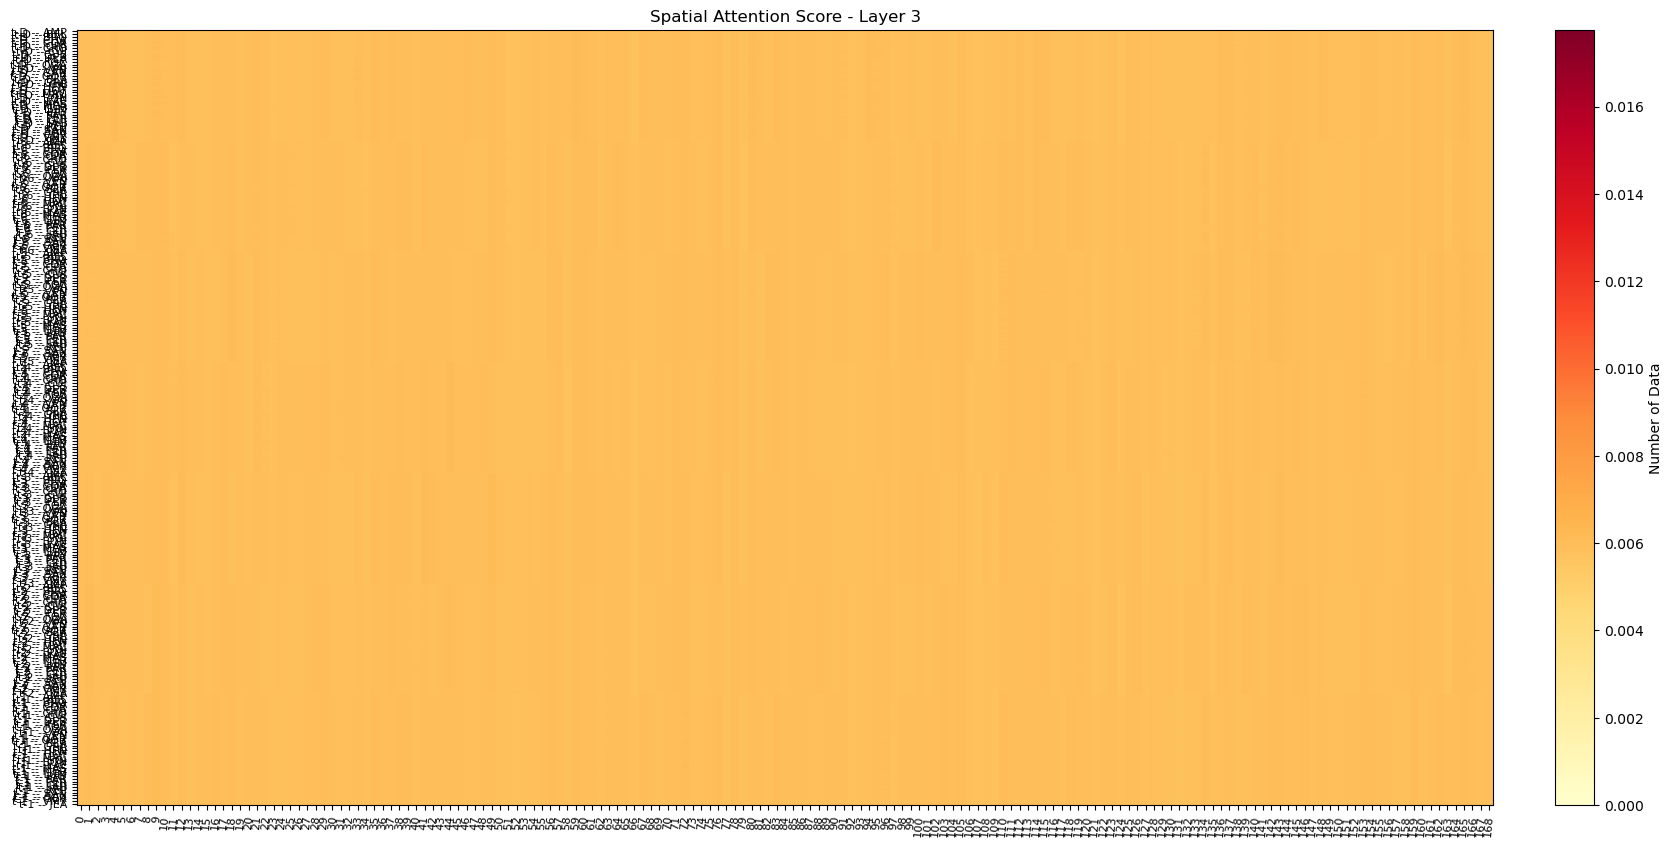

In [6]:
ds_name = 'netmob_POIs'


if hasattr(trainer.model.global_s_attn[f'{ds_name}'].model,'Q_attn_layers_t'):
    Q_attn_layers_t = trainer.model.global_s_attn[f'{ds_name}'].model.Q_attn_layers_t
    KV_attn_layers_t = trainer.model.global_s_attn[f'{ds_name}'].model.KV_attn_layers_t
    attn_layers_s = trainer.model.global_s_attn[f'{ds_name}'].model.attn_layers_s
else:
    attn_layers_t = trainer.model.global_s_attn[f'{ds_name}'].model.attn_layers_t
    attn_layers_s = trainer.model.global_s_attn[f'{ds_name}'].model.attn_layers_s


# --- Analysis of ST-Attention Weights associated to the contextual datasets: ---
for mha_layer in range(len(Q_attn_layers_t)):
    attn_score = Q_attn_layers_t[mha_layer].attn.attn_score.detach().cpu()
    mean_attn_score = attn_score.mean(0)
    df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.size(-1)).numpy(),
                                columns = t_columns,
                                index = [f"{hist} -- {s_unit}" for hist in t_columns for s_unit in ds.spatial_unit] )  # args_init.contextual_kwargs['netmob_POIs']['spatial_unit']
    figsize=(20,10)
    matfig = plt.figure(figsize=figsize)
    title = f"Temporal - Q Attention Score - Layer {mha_layer+1}"
    plot_coverage_matshow(df_attn_weight, cmap ="YlOrRd", 
                          save = None, cbar_label =  "Number of Data",
                          bool_reversed=False, v_min=0,v_max=3*(1/df_attn_weight.shape[1]),
                          bool_plot = True, cbar_magic_args = True, 
                          figsize = figsize,title=title)
    
    # ---

for mha_layer in range(len(KV_attn_layers_t)):
    attn_score = KV_attn_layers_t[mha_layer].attn.attn_score.detach().cpu()
    mean_attn_score = attn_score.mean(0)
    df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.size(-1)).numpy(),
                                columns = t_columns,
                                index = [f"{hist} -- {s_unit}" for hist in t_columns for s_unit in args.contextual_kwargs['netmob_POIs']['spatial_unit']] )  # 
    title = f"Temporal - KV Attention Score - Layer {mha_layer+1}"
    plot_coverage_matshow(df_attn_weight, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False, v_min=0,v_max=3*(1/df_attn_weight.shape[1]),bool_plot = True, cbar_magic_args = True, figsize = figsize,title=title)
    # ---


for mha_layer in range(len(attn_layers_s)):
    attn_score = attn_layers_s[mha_layer].attn.attn_score.detach().cpu()
    mean_attn_score = attn_score.mean(0)
    df_attn_weight = pd.DataFrame(mean_attn_score.reshape(-1,mean_attn_score.size(-1)).numpy(),
                                columns = args.contextual_kwargs[ds_name]['spatial_unit'],
                                index =[f"{hist} -- {s_unit}"   for hist in t_columns for s_unit in ds.spatial_unit] )
    title = f"Spatial Attention Score - Layer {mha_layer+1}"
    plot_coverage_matshow(df_attn_weight, cmap ="YlOrRd", save = None, cbar_label =  "Number of Data",bool_reversed=False, v_min=0,v_max=3*(1/df_attn_weight.shape[1]),bool_plot = True, cbar_magic_args = True, figsize = figsize, title=title)
    
    # ---

<Axes: >

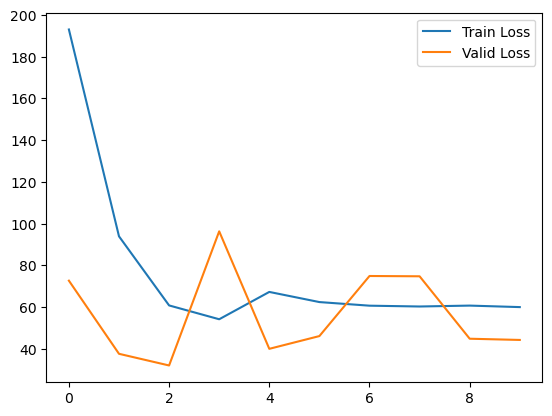

In [7]:
import pandas as pd
import numpy as np
df_losses = pd.DataFrame(np.stack([np.array(trainer.train_loss),np.array(trainer.valid_loss)],axis=1),
             columns = ['Train Loss','Valid Loss'])
df_losses.plot()

<Axes: >

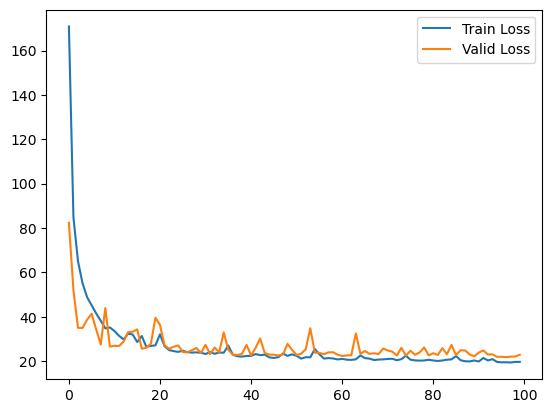

In [51]:
import pandas as pd
import numpy as np
df_losses = pd.DataFrame(np.stack([np.array(trainer.train_loss),np.array(trainer.valid_loss)],axis=1),
             columns = ['Train Loss','Valid Loss'])
df_losses.plot()

In [53]:
# No Clipping : 
# array([[170.84392562,  82.32574875],
#        [ 84.79164648,  51.98220085],
#        [ 64.9486567 ,  35.01090585],
#        [ 55.09561622,  34.96827794],
#        [ 48.82377496,  38.71367968],
#        [ 45.13454086,  41.30033438],
#        [ 41.4723823 ,  34.24349011],
#        [ 38.17766499,  27.49354124],
#        [ 34.7448583 ,  43.94368616],
#        [ 35.18114674,  26.56078761],
#        [ 33.56856619,  26.90162124],
#        [ 31.43226282,  26.81067662],
#        [ 29.75696714,  28.77440806],
#        [ 32.34024061,  33.05278485],
#        [ 32.02683949,  33.25360932],
#        [ 28.5974801 ,  34.30778469],
#        [ 31.32752202,  25.59620094],
#        [ 26.45776569,  26.02522383],
#        [ 26.83990355,  27.82408235],
#        [ 27.11863695,  39.55754432],
#        [ 32.06630996,  36.3234993 ],
#        [ 26.73326532,  27.08526761],
#        [ 24.9632036 ,  25.60490993],
#        [ 24.50546425,  26.46833441],
#        [ 24.16807319,  27.07353587],
#        [ 24.694057  ,  24.07384196],
#        [ 24.03805713,  23.97596379],
#        [ 23.8550757 ,  24.8914459 ],
#        [ 23.94436112,  25.93782084],
#        [ 23.74804346,  23.60376323],
#        [ 23.21205701,  27.34011918],
#        [ 24.09798667,  23.17411986],
#        [ 23.30368348,  26.11955468],
#        [ 23.88169874,  23.94436283],
#        [ 23.78575567,  32.94149451],
#        [ 27.01790803,  25.10436139],
#        [ 22.88184969,  22.8975947 ],
#        [ 22.18338579,  22.78021511],
#        [ 22.03233725,  23.20222728],
#        [ 22.31450784,  27.32940315],
#        [ 22.36726077,  22.57023446],
#        [ 23.17893995,  25.98621277],
#        [ 22.69261621,  30.19639522],
#        [ 22.92132933,  23.63661938],
#        [ 21.69241243,  22.92902157],
#        [ 21.42015952,  22.9046429 ],
#        [ 21.80907523,  22.52434674],
#        [ 23.4284587 ,  22.94423054],
#        [ 22.37295472,  27.76088723],
#        [ 23.03922726,  25.09457961],
#        [ 22.38735352,  22.72658644],
#        [ 21.12896964,  23.31552717],
#        [ 21.77728275,  25.38265198],
#        [ 21.70145423,  34.81169957],
#        [ 25.46969376,  23.7986581 ],
#        [ 23.08302222,  23.71873645],
#        [ 21.14796534,  23.09900472],
#        [ 21.36190964,  23.95471924],
#        [ 21.19918562,  23.99581592],
#        [ 20.75659962,  22.90746773],
#        [ 21.0172582 ,  22.31353929],
#        [ 20.64523605,  22.58167393],
#        [ 20.5542032 ,  22.624348  ],
#        [ 20.79546948,  32.50309887],
#        [ 22.55165539,  23.34830519],
#        [ 21.36322721,  24.56050127],
#        [ 21.11601216,  23.2850246 ],
#        [ 20.49873925,  23.5298664 ],
#        [ 20.71005595,  23.16835787],
#        [ 20.77967085,  25.67950781],
#        [ 20.97612192,  24.79802331],
#        [ 21.06996199,  24.26801056],
#        [ 20.38877005,  22.54665841],
#        [ 20.89122531,  25.9950611 ],
#        [ 22.41918824,  22.4598534 ],
#        [ 20.64135226,  24.67320255],
#        [ 20.33731918,  22.87059902],
#        [ 20.2310247 ,  23.88505953],
#        [ 20.28697129,  26.15585748],
#        [ 20.62675419,  22.57571831],
#        [ 20.27491079,  23.57187838],
#        [ 20.06888999,  22.77010824],
#        [ 20.28549177,  25.8360309 ],
#        [ 20.62936169,  23.11524513],
#        [ 20.80104744,  27.31812355],
#        [ 22.30587704,  22.69824646],
#        [ 20.4043225 ,  24.93361317],
#        [ 19.93269968,  24.77333945],
#        [ 19.86686925,  22.98446507],
#        [ 20.29139026,  22.18641493],
#        [ 19.83885662,  23.87207315],
#        [ 21.42188104,  24.80524512],
#        [ 20.30936279,  22.97427613],
#        [ 20.88238502,  23.0448061 ],
#        [ 19.63819088,  21.92558884],
#        [ 19.45827235,  21.95148018],
#        [ 19.48317592,  21.80576097],
#        [ 19.38810263,  22.01145754],
#        [ 19.64677834,  22.07687375],
#        [ 19.65665225,  22.87348653]])

<Axes: >

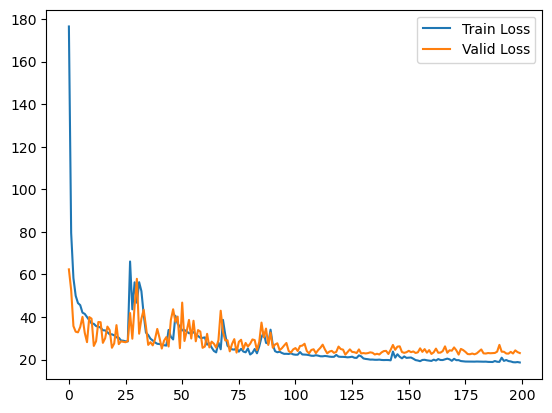

In [ ]:

import pandas as pd
import numpy as np
df_losses = pd.DataFrame(np.stack([np.array(trainer.train_loss),np.array(trainer.valid_loss)],axis=1),
             columns = ['Train Loss','Valid Loss'])
df_losses.plot()

In [ ]:
df_losses.values

# Clipping: 
# array([[176.53404675,  62.40024089],
#        [ 79.50823117,  52.68784529],
#        [ 58.29767825,  35.75335486],
#        [ 49.98329876,  33.09941319],
#        [ 46.57673842,  32.805002  ],
#        [ 45.57362998,  35.30578891],
#        [ 42.05999365,  40.06768187],
#        [ 41.47330545,  32.55073689],
#        [ 39.96122775,  28.19910508],
#        [ 38.47316796,  39.96946804],
#        [ 36.99975777,  39.23947804],
#        [ 36.80942572,  26.41970433],
#        [ 35.75110409,  28.6449457 ],
#        [ 35.46453434,  37.65925728],
#        [ 35.01043084,  37.55913474],
#        [ 33.78317742,  27.86526273],
#        [ 33.71571949,  30.01731187],
#        [ 32.8573174 ,  35.50297721],
#        [ 31.86884172,  33.85261171],
#        [ 31.87340882,  25.55399947],
#        [ 31.38913301,  27.59151029],
#        [ 30.42762801,  36.19853452],
#        [ 30.32218164,  27.25725308],
#        [ 28.97290523,  28.56377111],
#        [ 28.87437143,  28.35059275],
#        [ 28.59938472,  28.15574427],
#        [ 28.51275876,  28.72597561],
#        [ 66.09998339,  41.88390607],
#        [ 43.60559162,  29.80781471],
#        [ 56.31523357,  45.20083668],
#        [ 46.71909415,  57.95911547],
#        [ 56.38727304,  32.16068003],
#        [ 52.17976213,  39.23825003],
#        [ 41.31349028,  43.41659604],
#        [ 32.67214137,  35.56966634],
#        [ 31.54576976,  26.91002003],
#        [ 29.81268335,  28.18300729],
#        [ 28.98804009,  26.68571027],
#        [ 28.07686818,  29.55811361],
#        [ 27.42929945,  34.41031488],
#        [ 27.30505946,  30.19479987],
#        [ 26.94417714,  25.18890564],
#        [ 26.76673273,  28.89985565],
#        [ 26.57251394,  30.5735148 ],
#        [ 33.95325212,  26.15031897],
#        [ 30.71862138,  38.59633835],
#        [ 29.45802874,  43.65816134],
#        [ 40.61676441,  37.77984161],
#        [ 36.83355991,  40.21016657],
#        [ 35.46937336,  25.36078937],
#        [ 33.70245716,  46.78340735],
#        [ 33.90884491,  28.74804373],
#        [ 33.25446053,  33.38281735],
#        [ 32.36047012,  38.64233458],
#        [ 32.62722486,  29.90754056],
#        [ 32.91417636,  38.2490049 ],
#        [ 31.84213681,  28.60269245],
#        [ 31.07924154,  33.86350724],
#        [ 30.23131164,  33.1726614 ],
#        [ 30.19909784,  25.53757049],
#        [ 30.4413707 ,  26.12170064],
#        [ 27.00098568,  32.11638536],
#        [ 27.63542053,  25.72780693],
#        [ 25.66653758,  28.43684278],
#        [ 24.05623248,  27.44938665],
#        [ 23.39196247,  25.5996151 ],
#        [ 28.0231402 ,  29.12383944],
#        [ 24.83331569,  42.96357768],
#        [ 38.6623657 ,  33.00458234],
#        [ 31.70688259,  28.99119694],
#        [ 26.52607686,  29.08067061],
#        [ 25.53986391,  23.86826568],
#        [ 24.80383718,  27.31828957],
#        [ 24.67988986,  29.61466576],
#        [ 25.39962872,  23.27624495],
#        [ 23.73647233,  28.33543012],
#        [ 25.0656066 ,  29.31960844],
#        [ 23.76688946,  24.86808775],
#        [ 23.42037616,  27.81464733],
#        [ 25.22100988,  26.13596558],
#        [ 22.38025579,  27.43807811],
#        [ 23.17348865,  29.46536492],
#        [ 24.98377317,  29.15405993],
#        [ 22.95899135,  24.46957209],
#        [ 26.17900781,  28.26156551],
#        [ 30.5217514 ,  37.38630743],
#        [ 32.72887612,  30.45607166],
#        [ 27.87027425,  34.58445038],
#        [ 27.54448406,  26.90089021],
#        [ 34.05353354,  32.66512083],
#        [ 26.81279973,  25.59109458],
#        [ 23.94510256,  27.09583675],
#        [ 23.43755524,  27.65529453],
#        [ 23.71344612,  24.43964729],
#        [ 23.10724719,  25.33961928],
#        [ 22.69787114,  26.62557982],
#        [ 22.72552911,  27.80769015],
#        [ 22.64830281,  24.01730351],
#        [ 22.94372447,  23.31448715],
#        [ 22.44867507,  24.7972382 ],
#        [ 22.29220204,  25.417033  ],
#        [ 22.30668963,  24.03738006],
#        [ 23.54801819,  26.36938098],
#        [ 22.41239119,  26.57144695],
#        [ 22.33756673,  27.4396773 ],
#        [ 22.28731598,  24.01371608],
#        [ 22.09052209,  22.93714665],
#        [ 21.80741758,  24.53435111],
#        [ 21.77295128,  24.85038033],
#        [ 22.05036183,  23.03604628],
#        [ 21.8517787 ,  24.45804076],
#        [ 21.55956157,  25.55276846],
#        [ 21.54084122,  27.01195597],
#        [ 21.70166699,  24.75742261],
#        [ 21.5831738 ,  22.94920405],
#        [ 21.38465229,  23.76530937],
#        [ 21.29510387,  24.10472609],
#        [ 21.3163494 ,  23.17087134],
#        [ 22.20263815,  23.61866242],
#        [ 21.39752262,  26.11787666],
#        [ 21.29119295,  24.93153381],
#        [ 21.28002147,  24.68739395],
#        [ 21.20118635,  22.31483455],
#        [ 21.05945293,  23.58405519],
#        [ 21.16604209,  24.8095616 ],
#        [ 21.35560186,  23.60041161],
#        [ 20.86232178,  23.4682375 ],
#        [ 20.79125192,  23.08035468],
#        [ 21.9841155 ,  24.78047428],
#        [ 21.52193663,  22.90163579],
#        [ 20.53694586,  23.05429067],
#        [ 20.30532166,  22.88627666],
#        [ 20.17684859,  23.05759896],
#        [ 19.9934659 ,  23.4090535 ],
#        [ 20.01278361,  23.20087926],
#        [ 19.91285741,  22.40884276],
#        [ 19.90398735,  22.73308688],
#        [ 19.98376499,  22.40458601],
#        [ 19.82859969,  23.37643385],
#        [ 19.77454415,  23.99829218],
#        [ 19.81528032,  24.10130343],
#        [ 19.79144475,  22.63042155],
#        [ 19.65782623,  24.56230284],
#        [ 23.78428884,  26.88119621],
#        [ 20.91090445,  24.59235273],
#        [ 22.51974805,  26.09806272],
#        [ 21.31934823,  26.22823499],
#        [ 20.59456055,  23.54282124],
#        [ 21.48480903,  23.16648891],
#        [ 20.79882625,  23.4795143 ],
#        [ 20.91459872,  24.12153632],
#        [ 20.9726025 ,  23.48852955],
#        [ 20.41197255,  23.82414493],
#        [ 19.76850855,  23.1121316 ],
#        [ 19.56374176,  23.40509413],
#        [ 19.25013077,  25.28596627],
#        [ 19.82860025,  23.63462595],
#        [ 19.90951481,  24.92428456],
#        [ 19.66961686,  23.24629332],
#        [ 19.53210178,  24.44855909],
#        [ 19.3674024 ,  22.6460721 ],
#        [ 19.96935203,  23.41268681],
#        [ 19.5564723 ,  25.15833696],
#        [ 20.24288541,  23.22568771],
#        [ 19.81131531,  23.29038481],
#        [ 19.79325699,  23.99591236],
#        [ 20.143901  ,  26.21690145],
#        [ 20.45598638,  23.20780168],
#        [ 20.11339016,  24.36229733],
#        [ 19.4291889 ,  24.17816182],
#        [ 20.36486818,  25.71502836],
#        [ 19.7261096 ,  24.33770865],
#        [ 19.74942032,  22.3498521 ],
#        [ 19.31229471,  25.01984709],
#        [ 19.21261966,  24.47262055],
#        [ 19.08466351,  23.63012211],
#        [ 19.07024221,  22.60509751],
#        [ 19.04178114,  22.51561472],
#        [ 18.99808693,  22.84393768],
#        [ 19.03533896,  22.4901119 ],
#        [ 19.0891059 ,  22.91573098],
#        [ 19.06101525,  23.85236744],
#        [ 18.98923537,  24.76696841],
#        [ 19.00932639,  22.93530554],
#        [ 19.03907813,  22.84875604],
#        [ 18.9243402 ,  23.08769396],
#        [ 18.91164975,  22.98295178],
#        [ 18.86996523,  23.04692823],
#        [ 19.32705363,  23.11538368],
#        [ 18.99247982,  23.74020184],
#        [ 18.92775115,  26.91498666],
#        [ 20.88363979,  23.71585938],
#        [ 19.38870095,  23.66659921],
#        [ 19.81556804,  22.87489539],
#        [ 19.3060285 ,  22.79155608],
#        [ 19.13169621,  23.63339155],
#        [ 18.78112115,  22.85974899],
#        [ 18.70908428,  24.3315277 ],
#        [ 18.84537981,  23.51708998],
#        [ 18.64376836,  23.0705103 ]])

array([[176.53404675,  62.40024089],
       [ 79.50823117,  52.68784529],
       [ 58.29767825,  35.75335486],
       [ 49.98329876,  33.09941319],
       [ 46.57673842,  32.805002  ],
       [ 45.57362998,  35.30578891],
       [ 42.05999365,  40.06768187],
       [ 41.47330545,  32.55073689],
       [ 39.96122775,  28.19910508],
       [ 38.47316796,  39.96946804],
       [ 36.99975777,  39.23947804],
       [ 36.80942572,  26.41970433],
       [ 35.75110409,  28.6449457 ],
       [ 35.46453434,  37.65925728],
       [ 35.01043084,  37.55913474],
       [ 33.78317742,  27.86526273],
       [ 33.71571949,  30.01731187],
       [ 32.8573174 ,  35.50297721],
       [ 31.86884172,  33.85261171],
       [ 31.87340882,  25.55399947],
       [ 31.38913301,  27.59151029],
       [ 30.42762801,  36.19853452],
       [ 30.32218164,  27.25725308],
       [ 28.97290523,  28.56377111],
       [ 28.87437143,  28.35059275],
       [ 28.59938472,  28.15574427],
       [ 28.51275876,  28.72597561],
 